In [1]:
from fastai.collab import *
from fastai.tabular import *
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
ratings = pd.read_csv('./output_plays_small_preprocessed.csv')
ratings.head()
ratings.shape

(999882, 3)

In [3]:
ratings.columns = ['userID', 'songID', 'playCount']



In [4]:
ratings['playCount'].value_counts()


0    956746
1     29279
2      7420
3      2879
5      2138
4      1420
Name: playCount, dtype: int64

In [5]:
train_set, test_set = train_test_split(ratings, test_size=0.20, random_state=42)

print(train_set.shape)
print(test_set.shape)

(799905, 3)
(199977, 3)


In [6]:
data = CollabDataBunch.from_df(train_set, seed=42, valid_pct=0.2)


In [7]:
data.show_batch()

userID,songID,target
6382820f9ca77ba05f1b9a1df5839d8ecf8bae0a,SOHHCGC12AB018939A,0.0
d6dcd54a3762ac06e563aedd5182845c15eff8e5,SOYFGYE12A670215BE,0.0
372d3657473945bae2f66d28e500f75053cd6673,SORXFLV12AB018C292,0.0
1214c44d469cb48496073514c695fa07fcd0199a,SOBBKGF12A8C1311EE,0.0
86fb9e8b68955b378d07bdc77ef0edb1304516ce,SOIUJLL12A8C13F676,0.0


After data preparation, EmbeddingDotBias and EmbeddingNN approaches were tested. EmbeddingDotBias is a Pytorch model used to find embeddings using multi-layer perceptron without biases and with one hidden layer. EmbeddingNN approach, on the other hand, creates a deeper Neural Network suitable for collaborative filtering. It is expected that EmbeddingNN, due to it's bigger complexity of layers is a slower but far more accurate.

## EmbeddingDotBias Model

In [8]:
learn = collab_learner(data, n_factors=50, y_range=(0, 5))

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


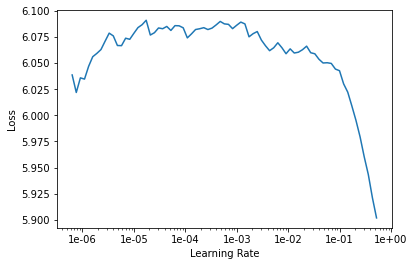

In [9]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [12]:
learn.fit_one_cycle(10, 1e-6)

epoch,train_loss,valid_loss,time
0,0.760962,0.872820,30:52
1,0.749905,0.872643,32:27
2,0.830461,0.872330,32:55
3,0.769353,0.871993,33:05
4,0.760028,0.871689,32:57
5,0.754670,0.871445,32:53
6,0.750180,0.871277,32:51
7,0.717178,0.871186,32:18
8,0.704273,0.871156,32:03
9,0.664921,0.871154,31:48


## EmbeddingNN Model

In [8]:
learn = collab_learner(data, use_nn=True, emb_szs={'userID': 50, 'songID': 50}, layers=[256, 128], y_range=(0, 5))

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


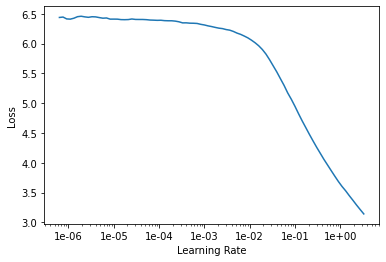

In [9]:
learn.lr_find()
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,time
0,0.150604,0.155372,22:50
1,0.135050,0.154757,32:03
2,0.156423,0.157439,33:02
3,0.159002,0.157189,33:28
4,0.127987,0.154186,33:14
5,0.147431,0.151811,33:23
6,0.127835,0.153880,32:47
7,0.142886,0.155044,32:08
8,0.097612,0.163690,31:36
9,0.099753,0.171441,31:10


In [69]:
learn.save('./model-5')

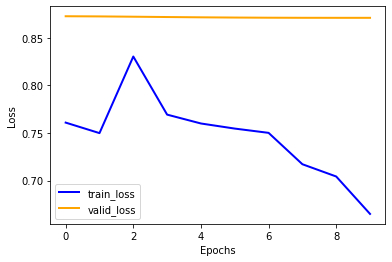

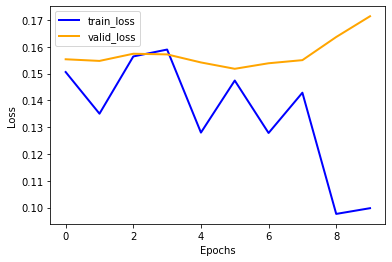

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_training(losses_df):
    # Data
    df=pd.DataFrame({'x_values': range(0, 10), 'y1_values': losses_df['train_loss'], 'y2_values': losses_df['valid_loss']})

    # multiple line plots
    plt.plot( 'epoch', 'train_loss', data=losses_df, marker='', color='blue', linewidth=2)
    plt.plot( 'epoch', 'valid_loss', data=losses_df, marker='', color='orange', linewidth=2)
    
    # add labels
    plt.xlabel("Epochs")
    
    plt.ylabel("Loss")

    # show legend
    plt.legend()

    # show graph
    plt.show()

plot_training(pd.DataFrame([[0, 0.760962, 0.872820], [1, 0.749905, 0.872643], [2, 0.830461, 0.872330], [3, 0.769353, 0.871993], [4, 0.760028, 0.871689], [5, 0.754670, 0.871445], [6, 0.750180, 0.871277], [7, 0.717178, 0.871186], [8, 0.704273, 0.871156], [9, 0.664921, 0.871154]], columns=['epoch', 'train_loss', 'valid_loss']))
plot_training(pd.DataFrame([[0, 0.150604, 0.155372], [1, 0.135050, 0.154757], [2, 0.156423, 0.157439], [3, 0.159002, 0.157189], [4, 0.127987, 0.154186], [5, 0.147431, 0.151811], [6, 0.127835, 0.153880], [7, 0.142886, 0.155044], [8, 0.097612, 0.163690], [9, 0.099753, 0.171441]], columns=['epoch', 'train_loss', 'valid_loss']))

## Evaluate trained model

Evaluate trained model on test dataset and compute RMSE.

In [71]:
test_data = CollabDataBunch.from_df(train_set, test=test_set, seed=42, valid_pct=0.2)
test_data.show_batch()
test_learn = collab_learner(test_data, use_nn=True, emb_szs={'userID': 50, 'songID': 50}, layers=[256, 128], y_range=(0, 5))
learn_loaded = test_learn.load('./model-5')



userID,songID,target
4a3ed52a06359e197f751707c629de5c1536fcdb,SOLXXZI12A8AE4733A,1.0
6dab635b404578aa80b044e6f4ebe39d8379daed,SONCOJJ12A6701FC24,0.0
937b77575b74f9e22ed027c9c200eb87a6b4dde1,SOAODHY12A8C13C8B5,0.0
03f7e4ac0d94229253aa4c5f6801e23d268ba1aa,SOPPGAC12A6D4F87E1,0.0
ffa9ef2e0d1034dcf7973896febb1eb9f6b359cb,SOTVKPX12AF72A556D,0.0


In [72]:
preds, y = learn_loaded.get_preds(DatasetType.Test)

In [12]:
from sklearn.metrics import mean_squared_error

songs = test_set[['songID', 'playCount']]

rmse = mean_squared_error(preds, songs['playCount'], squared=False)
rmse

0.3660267338792369
